## NAIVER STOKES MODEL

In [1]:
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
from scipy.integrate import odeint

class NavierStokesMarketMaker:
    def __init__(self, data, lookback=20):
        self.data = data
        self.lookback = lookback
        self.prepare_data()

    def prepare_data(self):
        self.data['Momentum'] = self.calculate_momentum()
        self.data['WR'] = self.calculate_williams_r()
        self.data['CMF'] = self.calculate_cmf()
        self.data['Volatility'] = self.calculate_volatility()

    def calculate_momentum(self):
        return self.data['Close'] - self.data['Close'].shift(5)

    def calculate_williams_r(self):
        high = self.data['High'].rolling(14).max()
        low = self.data['Low'].rolling(14).min()
        close = self.data['Close']
        return (high - close) / (high - low)

    def calculate_cmf(self):
        money_flow_multiplier = ((self.data['Close'] - self.data['Low']) -
                                 (self.data['High'] - self.data['Close'])) / (self.data['High'] - self.data['Low'])
        money_flow_volume = money_flow_multiplier * self.data['Volume']
        return money_flow_volume.rolling(21).sum() / self.data['Volume'].rolling(21).sum()

    def calculate_density(self, promoter_holding, paid_up_capital):
        return self.data['Volume'] / ((1 - promoter_holding) * paid_up_capital)

    def calculate_volatility(self):
        return self.data['Close'].pct_change().rolling(20).std()

    def navier_stokes_model(self, y, t, params):
        momentum, wr, cmf, density, volatility = y
        a, b, c, d, e = params

        dmdt = a * momentum + b * wr + c * cmf + d * density + e * volatility
        dwrdt = -momentum
        dcmfdt = -momentum
        ddendt = 0
        dvoldt = 0

        return [dmdt, dwrdt, dcmfdt, ddendt, dvoldt]

    def solve_navier_stokes(self, initial_conditions, params, t):
        solution = odeint(self.navier_stokes_model, initial_conditions, t, args=(params,))
        return solution[:, 0]  # return momentum value

    def calculate_fair_price(self, row, promoter_holding, paid_up_capital):
        momentum = row['Momentum']
        wr = row['WR']
        cmf = row['CMF']
        density = self.calculate_density(promoter_holding, paid_up_capital).loc[row.name]
        volatility = row['Volatility']

        # Parameters for the Navier-Stokes model
        params = (0.1, -0.2, 0.3, -0.1, 0.2)

        t = np.linspace(0, 1, 2)
        initial_conditions = [momentum, wr, cmf, density, volatility]

        predicted_momentum = self.solve_navier_stokes(initial_conditions, params, t)
        fair_price = row['Close'] + predicted_momentum[-1]

        return fair_price

class BacktestMarketMaker(NavierStokesMarketMaker):
    def __init__(self, data, lookback=20, spread=0.0025, promoter_holding=0.75, paid_up_capital=1000000):
        super().__init__(data, lookback)
        self.spread = self.data['Close'].mean()*spread
        self.promoter_holding = promoter_holding
        self.paid_up_capital = paid_up_capital
        self.trades = []
        self.data['Fair_Price'] = np.nan
        self.data['Buy_Price'] = np.nan
        self.data['Sell_Price'] = np.nan

    def run_backtest(self):

        for i in tqdm(range(len(self.data))):
            row = self.data.iloc[i]
            fair_price = self.calculate_fair_price(row, self.promoter_holding, self.paid_up_capital)
            self.data.at[row.name, 'Fair_Price'] = fair_price

        self.data['VWAP_Fair_Price'] = (
            self.data['Fair_Price'] * self.data['Volume']
        ).rolling(window=5).sum() / self.data['Volume'].rolling(window=5).sum()

        self.data['Buy_Price'] = self.data['VWAP_Fair_Price'] - self.spread
        self.data['Sell_Price'] = self.data['VWAP_Fair_Price'] + self.spread
        self.data.to_csv("result_prices.csv")
        i=1

        while (i<=(len(self.data)-1)):
            prev_row = self.data.iloc[i-1]
            row = self.data.iloc[i]

            buy_price = prev_row['Buy_Price']
            sell_price = prev_row['Sell_Price']

            # Long
            if row['Low']<buy_price:
                entry_price = buy_price

                j=i+1
                if(j==len(self.data)):
                    exit_price = buy_price
                    self.trades.append({
                        'Trade': 'Long', 'Entry': entry_price, 'Exit': exit_price,
                        'PnL': entry_price - exit_price, 'Fair_Price': prev_row['Fair_Price'],
                        'Close_Price': row['Close']
                    })
                    break
                while(j<=min(len(self.data)-1,i+15+1)):
                    exit_row = self.data.iloc[j]
                    sell_price=exit_row['Sell_Price']
                    if  sell_price< exit_row['High']:
                        exit_price = sell_price
                        self.trades.append({
                            'Trade': 'Long', 'Entry': entry_price, 'Exit': exit_price,
                            'PnL': exit_price - entry_price, 'Fair_Price': prev_row['Fair_Price'],
                            'Close_Price': row['Close']
                        })

                        i = j+1
                        print(f"Buy Trade done at {i}")
                        break
                    elif(j==(i+15+1)):
                        j+=1
                        exit_price = sell_price
                        self.trades.append({
                            'Trade': 'Long', 'Entry': entry_price, 'Exit': exit_price,
                            'PnL': exit_price - entry_price, 'Fair_Price': prev_row['Fair_Price'],
                            'Close_Price': row['Close']
                        })
                        i=j+1
                        break

                    elif(j==len(self.data)-1):
                        # Exit Irrespective of Anything
                        exit_price = sell_price
                        j+=1
                        self.trades.append({
                            'Trade': 'Long', 'Entry': entry_price, 'Exit': exit_price,
                            'PnL': exit_price - entry_price, 'Fair_Price': prev_row['Fair_Price'],
                            'Close_Price': row['Close']
                        })
                        i=j
                        break
                    else:
                        j+=1


            # Short
            elif row['High']>sell_price:
                entry_price = sell_price

                j=i+1
                if(j>=len(self.data)):
                    exit_price = buy_price
                    self.trades.append({
                        'Trade': 'Long', 'Entry': entry_price, 'Exit': exit_price,
                        'PnL': entry_price - exit_price, 'Fair_Price': prev_row['Fair_Price'],
                        'Close_Price': row['Close']
                    })
                    break
                while(j<=min(len(self.data)-1,i+15+1)):
                    exit_row = self.data.iloc[j]
                    buy_price=exit_row['Buy_Price']
                    if  buy_price> exit_row['Low']:
                        exit_price = buy_price
                        self.trades.append({
                            'Trade': 'Long', 'Entry': entry_price, 'Exit': exit_price,
                            'PnL': entry_price - exit_price, 'Fair_Price': prev_row['Fair_Price'],
                            'Close_Price': row['Close']
                        })

                        i = j+1
                        print(f"Sell Trade done at {i}")
                        break
                    elif(j==(i+15+1)):
                        j+=1
                        exit_price = buy_price
                        self.trades.append({
                            'Trade': 'Long', 'Entry': entry_price, 'Exit': exit_price,
                            'PnL': entry_price - exit_price, 'Fair_Price': prev_row['Fair_Price'],
                            'Close_Price': row['Close']
                        })
                        i=j+1
                        break

                    elif(j==len(self.data)-1):
                        # Exit Irrespective of Anything
                        j+=1
                        exit_price = buy_price
                        self.trades.append({
                            'Trade': 'Long', 'Entry': entry_price, 'Exit': exit_price,
                            'PnL': entry_price - exit_price, 'Fair_Price': prev_row['Fair_Price'],
                            'Close_Price': row['Close']
                        })
                        i=j
                        break
                    else:
                        j+=1
            else:
                i+=1

    def calculate_sharpe_ratio(self, returns, risk_free_rate = 6):
        # Taking a 6% annnualized risk free rate
        rfr = risk_free_rate/ 252

        excess_returns = returns - rfr

        return np.mean(excess_returns) * math.sqrt(252) / np.std(excess_returns)

    def calculate_sortino_ratio(self, returns, rfr = 6):
        # Taking a 6% annnualized risk free rate
        risk_free_rate = rfr / 252

        downside_risk = np.std([r for r in returns if r < risk_free_rate])
        return np.mean(returns - risk_free_rate) * math.sqrt(252) / downside_risk if downside_risk != 0 else np.inf

    def calculate_max_drawdown(self, returns):

        cumulative_pnl = pd.Series(np.cumsum(returns))
        dd = (cumulative_pnl.cummax() - cumulative_pnl) / (cumulative_pnl.cummax() + self.initial_capital)
        max_drawdown = dd.max() * 100

        return max_drawdown

    def calculate_pnl(self, initial_capital):
        pnl = pd.DataFrame(self.trades)
        pnl.dropna(inplace=True)

        self.initial_capital = initial_capital
        capital = initial_capital
        compounded_pnl = []
        percentage_returns = []
        kelly_fractions = []

        # Calculate PnL with compounding and Kelly Criterion
        for i, trade in pnl.iterrows():
            entry_price = trade['Entry']
            trade_pnl = trade['PnL']

            if i >= 10:
                winning_trades = len(pnl[pnl['PnL'] > 0])
                losing_trades = len(pnl[pnl['PnL'] < 0])

                if winning_trades + losing_trades > 0:
                    prob_win = winning_trades / (winning_trades + losing_trades)
                    win_loss_ratio = pnl[pnl['PnL'] > 0]['PnL'].mean() / abs(pnl[pnl['PnL'] < 0]['PnL'].mean())

                    kelly_fraction = prob_win - (1 - prob_win) / win_loss_ratio
                else:
                    kelly_fraction = 0
            else:
                kelly_fraction = 0

            kelly_fractions.append(kelly_fraction)
            position_size = capital * kelly_fraction / entry_price if kelly_fraction > 0 else 0

            trade_return = position_size * trade_pnl
            compounded_pnl.append(trade_return)
            capital += trade_return
            percentage_return = (trade_return / capital) * 100 if capital > 0 else 0
            percentage_returns.append(percentage_return)

        pnl['Compounded_PnL'] = compounded_pnl
        pnl['Percentage_Return'] = percentage_returns
        pnl['Kelly_Fraction'] = kelly_fractions

        total_pnl = sum(compounded_pnl)
        winning_trades = len(pnl[pnl['Compounded_PnL'] > 0])
        losing_trades = len(pnl[pnl['Compounded_PnL'] < 0])

        sharpe_ratio = self.calculate_sharpe_ratio(pnl['Percentage_Return'].values)
        sortino_ratio = self.calculate_sortino_ratio(pnl['Percentage_Return'].values)
        max_drawdown = self.calculate_max_drawdown(pnl['Compounded_PnL'].values)

        return total_pnl, winning_trades, losing_trades, sharpe_ratio, sortino_ratio, max_drawdown



df = pd.read_csv("/content/INFTEC_cash.csv")
df.columns = df.columns.str.capitalize()
backtest = BacktestMarketMaker(df)

initial_capital = 1000000
backtest.run_backtest()
total_pnl, winning_trades, losing_trades, sharpe_ratio, sortino_ratio, max_drawdown = backtest.calculate_pnl(initial_capital)

# print(f"Total PnL: {total_pnl*100/initial_capital :.2f} %")
# print(f"Winning Trades: {winning_trades}")
# print(f"Losing Trades: {losing_trades}")
# print(f"Sharpe Ratio: {sharpe_ratio :.3f}")
# print(f"Sortino Ratio: {sortino_ratio :.3f}")
# print(f"Max Drawdown: {max_drawdown :.2f} %")


  0%|          | 0/102676 [00:00<?, ?it/s]<ipython-input-1-f280bf1ce9c5>:53: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(self.navier_stokes_model, initial_conditions, t, args=(params,))
<ipython-input-1-f280bf1ce9c5>:53: ODEintWarning: Run terminated (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(self.navier_stokes_model, initial_conditions, t, args=(params,))
100%|██████████| 102676/102676 [01:38<00:00, 1044.74it/s]


Sell Trade done at 16
Buy Trade done at 20
Sell Trade done at 29
Buy Trade done at 465
Sell Trade done at 469
Sell Trade done at 1031
Buy Trade done at 1089
Buy Trade done at 2025
Sell Trade done at 2032
Buy Trade done at 2157
Sell Trade done at 2458
Sell Trade done at 2587
Buy Trade done at 2781
Buy Trade done at 2819
Sell Trade done at 2824
Buy Trade done at 2882
Sell Trade done at 2905
Buy Trade done at 3175
Sell Trade done at 3189
Sell Trade done at 3419
Sell Trade done at 3494
Buy Trade done at 3571
Sell Trade done at 3581
Buy Trade done at 3584
Sell Trade done at 3590
Sell Trade done at 3623
Buy Trade done at 3634
Sell Trade done at 3638
Buy Trade done at 3681
Sell Trade done at 3698
Buy Trade done at 3893
Buy Trade done at 3974
Buy Trade done at 4018
Sell Trade done at 4143
Buy Trade done at 4219
Sell Trade done at 5184
Buy Trade done at 5380
Sell Trade done at 5428
Sell Trade done at 5472
Buy Trade done at 5486
Sell Trade done at 6261
Buy Trade done at 6273
Buy Trade done at 63

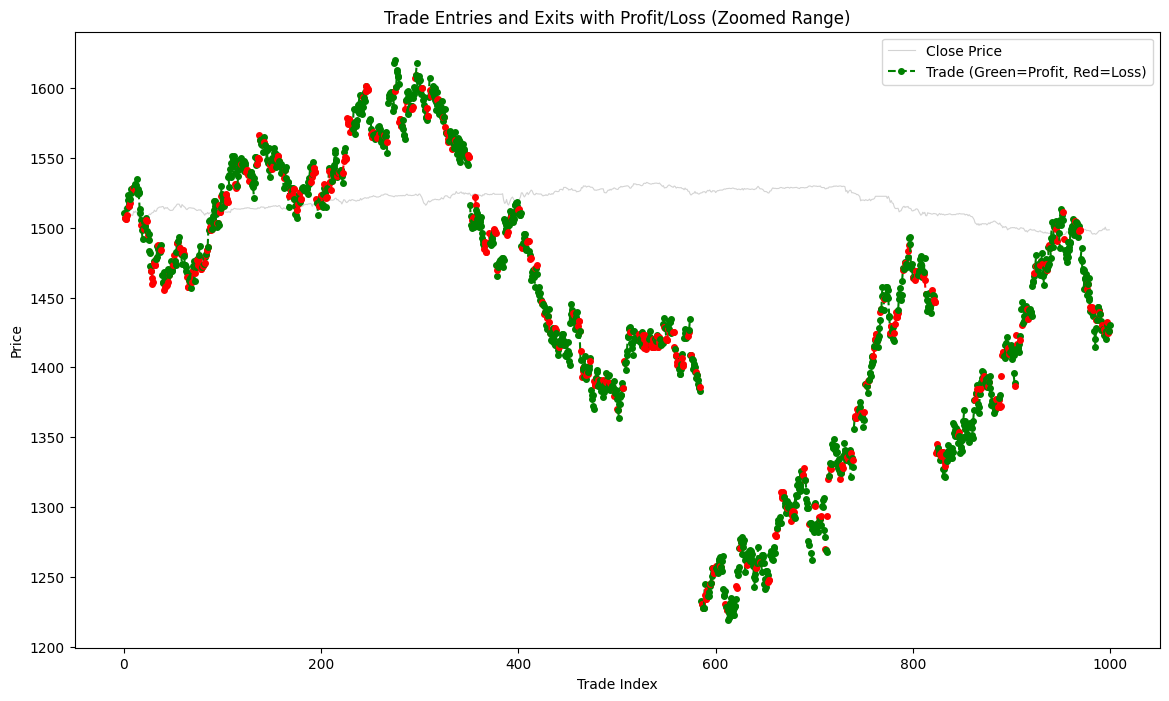

In [8]:
import matplotlib.pyplot as plt

def plot_trade_log(pnl_df, data, start=0, end=1000):
    """
    Plots trade entries and exits over a limited range for clarity.
    Parameters:
        - pnl_df: DataFrame containing trades.
        - data: Full price data.
        - start: Start index for data to plot.
        - end: End index for data to plot.
    """
    # Slice the data for the specified range
    sliced_data = data.iloc[start:end]
    trades_in_range = pnl_df[(pnl_df.index >= start) & (pnl_df.index < end)]

    plt.figure(figsize=(14, 8))
    plt.plot(sliced_data['Close'], label="Close Price", color="lightgray", linewidth=0.8)

    # Plot buy and sell trades with color coding for profit/loss
    for i, row in trades_in_range.iterrows():
        color = 'green' if row['PnL'] > 0 else 'red'
        entry = row['Entry']
        exit = row['Exit']
        plt.plot([i, i + 1], [entry, exit], color=color, linestyle='--', marker='o', markersize=4)

    plt.title("Trade Entries and Exits with Profit/Loss (Zoomed Range)")
    plt.xlabel("Trade Index")
    plt.ylabel("Price")
    plt.legend(["Close Price", "Trade (Green=Profit, Red=Loss)"])
    plt.show()

# Call the plot function with a limited range for clarity
plot_trade_log(pnl_df, backtest.data, start=0, end=1000)


In [7]:
import plotly.graph_objects as go
import pandas as pd

def interactive_trade_log(pnl_df, data, start=0, end=200):
    """
    Creates an interactive Plotly plot for trade entries and exits over a limited range.
    Parameters:
        - pnl_df: DataFrame containing trades.
        - data: Full price data.
        - start: Start index for data to plot.
        - end: End index for data to plot.
    """
    # Slice the data for the specified range
    sliced_data = data.iloc[start:end].reset_index()
    trades_in_range = pnl_df[(pnl_df.index >= start) & (pnl_df.index < end)]

    # Initialize Plotly figure
    fig = go.Figure()

    # Add Close Price Line
    fig.add_trace(go.Scatter(x=sliced_data.index, y=sliced_data['Close'],
                             mode='lines', name='Close Price',
                             line=dict(color='lightgray', width=1)))

    # Add Buy and Sell trades with minimal annotations
    for i, row in trades_in_range.iterrows():
        color = 'green' if row['PnL'] > 0 else 'red'

        # Entry point
        fig.add_trace(go.Scatter(
            x=[i], y=[row['Entry']],
            mode='markers',
            marker=dict(color='green' if row['Trade'] == 'Long' else 'red', size=6, symbol='triangle-up' if row['Trade'] == 'Long' else 'triangle-down'),
            name="Entry",
            hovertemplate=f"Entry Price: {row['Entry']}"
        ))

        # Exit point
        fig.add_trace(go.Scatter(
            x=[i + 1], y=[row['Exit']],
            mode='markers',
            marker=dict(color=color, symbol="x", size=6),
            name="Exit",
            hovertemplate=f"Exit Price: {row['Exit']}<br>PnL: {row['PnL']:.2f}"
        ))

        # Trade line between Entry and Exit
        fig.add_trace(go.Scatter(
            x=[i, i + 1], y=[row['Entry'], row['Exit']],
            mode='lines',
            line=dict(color=color, dash='dash', width=1),
            hoverinfo='skip'  # Only show hover info on points
        ))

    # Update layout for better interactivity
    fig.update_layout(
        title="Interactive Trade Log with Profit/Loss (Subset of Trades)",
        xaxis_title="Trade Index",
        yaxis_title="Price",
        template="plotly_white",
        hovermode="closest",
        showlegend=False  # Hide legend to reduce clutter
    )

    fig.show()

# Run the interactive plot function with a limited trade range
pnl_df = pd.DataFrame(backtest.trades)
interactive_trade_log(pnl_df, backtest.data, start=0, end=2000)


In [3]:
from tabulate import tabulate

# Organize metrics into a structured format
metrics = [
    ["Total PnL (%)", f"{total_pnl * 100 / initial_capital:.2f} %"],
    ["Winning Trades", winning_trades],
    ["Losing Trades", losing_trades],
    ["Sharpe Ratio", f"{sharpe_ratio:.3f}"],
    ["Sortino Ratio", f"{sortino_ratio:.3f}"],
    ["Max Drawdown (%)", f"{max_drawdown:.2f} %"]
]

# Display using tabulate for a clean table view
print("\nBacktest Performance Summary\n")
print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="grid"))



Backtest Performance Summary

+------------------+----------+
| Metric           | Value    |
+==================+==========+
| Total PnL (%)    | 207.68 % |
+------------------+----------+
| Winning Trades   | 899      |
+------------------+----------+
| Losing Trades    | 365      |
+------------------+----------+
| Sharpe Ratio     | 6.252    |
+------------------+----------+
| Sortino Ratio    | 11.908   |
+------------------+----------+
| Max Drawdown (%) | 1.55 %   |
+------------------+----------+


##Fetching market data using ICICI Breeze API



In [4]:
# test = breeze.get_historical_data(interval="1minute",
#                                         from_date= f"{first_day_of_current_month_str}T07:00:00.000Z",
#                                         to_date= f"{first_day_of_next_month_str}T07:00:00.000Z",
#                                         stock_code=ticker,
#                                         exchange_code="NFO",
#                                         product_type="options",
#                                         expiry_date=f"{exp}T07:00:00.000Z",
#                                         right=opt_type,
#                                         strike_price=strike)